# Description

Generates the figure for top cell types for a specified LV (in Settings section below).

# Modules loading

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from data.recount2 import LVAnalysis
from utils import chunker
import conf

# Settings

In [3]:
LV_NAME = "LV21"

In [4]:
LV_AXIS_THRESHOLD = 3.0
N_TOP_SAMPLES = 200
N_TOP_ATTRS = 25

In [5]:
OUTPUT_FIGURES_DIR = Path(
    conf.MANUSCRIPT["FIGURES_DIR"], "lvs_analysis", f"{LV_NAME.lower()}"
).resolve()
display(OUTPUT_FIGURES_DIR)
OUTPUT_FIGURES_DIR.mkdir(parents=True, exist_ok=True)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier_manuscript/content/images/lvs_analysis/lv21')

In [6]:
OUTPUT_CELL_TYPE_FILEPATH = OUTPUT_FIGURES_DIR / f"{LV_NAME.lower()}-cell_types.svg"
display(OUTPUT_CELL_TYPE_FILEPATH)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier_manuscript/content/images/lvs_analysis/lv21/lv21-cell_types.svg')

# Load MultiPLIER summary

In [7]:
multiplier_model_summary = pd.read_pickle(conf.MULTIPLIER["MODEL_SUMMARY_FILE"])

In [8]:
multiplier_model_summary.shape

(2157, 5)

In [9]:
multiplier_model_summary.head()

,pathway,LV index,AUC,p-value,FDR
1,KEGG_LYSINE_DEGRADATION,1,0.388059,0.866078,0.956005
2,REACTOME_MRNA_SPLICING,1,0.733057,0.000048,0.000582
3,MIPS_NOP56P_ASSOCIATED_PRE_RRNA_COMPLEX,1,0.680555,0.001628,0.011366
4,KEGG_DNA_REPLICATION,1,0.549473,0.312155,0.539951
5,PID_MYC_ACTIVPATHWAY,1,0.639303,0.021702,0.083739


# Load data

## Original data

In [10]:
INPUT_SUBSET = "z_score_std"

In [11]:
INPUT_STEM = "projection-smultixcan-efo_partial-mashr-zscores"

In [12]:
input_filepath = Path(
    conf.RESULTS["DATA_TRANSFORMATIONS_DIR"],
    INPUT_SUBSET,
    f"{INPUT_SUBSET}-{INPUT_STEM}.pkl",
).resolve()
display(input_filepath)

assert input_filepath.exists(), "Input file does not exist"

input_filepath_stem = input_filepath.stem
display(input_filepath_stem)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/bases_data/base_orig/results/data_transformations/z_score_std/z_score_std-projection-smultixcan-efo_partial-mashr-zscores.pkl')

'z_score_std-projection-smultixcan-efo_partial-mashr-zscores'

In [13]:
data = pd.read_pickle(input_filepath)

In [14]:
data.shape

(3752, 987)

In [15]:
data.head()

,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,LV10,...,LV978,LV979,LV980,LV981,LV982,LV983,LV984,LV985,LV986,LV987
100001_raw-Food_weight,-0.695006,1.962565,0.057683,0.878731,-0.539977,1.481272,-0.396422,1.090180,0.759223,0.931395,...,1.129784,1.752343,-1.411403,2.823863,0.931116,-1.054519,0.432982,-0.633597,0.554279,-0.642479
100002_raw-Energy,-1.528127,-0.345309,-0.148953,-0.242060,0.373427,0.791092,0.263477,0.987702,0.354391,1.416059,...,0.224604,0.769882,-0.509482,0.091153,2.286789,-1.008256,-0.029764,1.737229,-0.272107,-0.526125
100003_raw-Protein,-0.704572,-1.011299,0.671420,0.143991,0.615212,0.874212,-0.040998,0.915170,0.254369,-0.084237,...,1.003019,1.044314,-2.376108,0.004778,0.053714,-0.892447,-0.183800,1.377991,-0.278794,-0.419733
100004_raw-Fat,-0.989832,-1.875490,0.261555,-1.420719,0.366238,1.167049,0.257387,0.717674,-0.997664,0.969825,...,0.585913,0.638314,0.119139,-0.140204,1.394326,-1.173402,0.555058,1.013982,-0.544506,-0.064061
100005_raw-Carbohydrate,-0.580143,0.243335,0.158966,-0.036558,0.068176,-0.202639,1.101281,0.675227,1.463432,1.010078,...,-0.249108,-0.026814,0.232713,0.323682,1.168642,-0.282935,0.653105,1.909526,0.199997,-1.656894


## LV data

In [16]:
lv_obj = LVAnalysis(LV_NAME, data)

In [17]:
multiplier_model_summary[
    multiplier_model_summary["LV index"].isin((LV_NAME[2:],))
    & (
        (multiplier_model_summary["FDR"] < 0.05)
        | (multiplier_model_summary["AUC"] >= 0.75)
    )
]

[2021-08-02 22:31:34,947 - numexpr.utils] INFO: NumExpr defaulting to 8 threads.


,pathway,LV index,AUC,p-value,FDR


In [18]:
lv_data = lv_obj.get_experiments_data()

SRP036821, SRP019994, SRP056733, SRP034953, SRP006575, SRP015670, SRP009251, SRP039361, SRP017575, SRP042031, SRP033276, SRP057196, SRP039338, SRP042161, SRP039591, SRP027383, SRP007359, SRP052740, SRP050146, SRP051368, SRP023262, SRP044668, SRP055513, SRP063838, SRP065445, SRP019936, SRP056696, SRP007338, SRP055569, SRP020470, SRP055153, SRP056840, SRP050000, SRP056295, SRP007461, SRP053101, SRP003726, SRP041538, SRP048801, SRP058237, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (39 != 40)
  warnings.warn(


In [19]:
lv_data.shape

(4996, 60)

In [20]:
lv_data.head()

tissue tissue subtype  \
project   run                                              
SRP036821 SRR1163240  soft tissue sarcoma        GIST WT   
          SRR1163241  soft tissue sarcoma        GIST WT   
          SRR1163242  soft tissue sarcoma        GIST WT   
          SRR1163243  soft tissue sarcoma        GIST WT   
          SRR1163244  soft tissue sarcoma        GIST WT   

                     tissue archive method             source subtypes  \
project   run                                                            
SRP036821 SRR1163240                  FFPE  Stanford Surgical      NaN   
          SRR1163241                  FFPE  Stanford Surgical      NaN   
          SRR1163242                  FFPE  Stanford Surgical      NaN   
          SRR1163243                  FFPE  Stanford Surgical      NaN   
          SRR1163244                  FFPE  Stanford Surgical      NaN   

                     individual agent time point batch  rin  ...  \
project   run                                                ...   
SRP036821 SRR1163240        NaN   NaN        NaN   NaN  NaN  ...   
          SRR1163241        NaN   NaN        NaN   NaN  NaN  ...   
          SRR1163242        NaN   NaN        NaN   NaN  NaN  ...   
          SRR1163243        NaN   NaN        NaN   NaN  NaN  ...   
          SRR1163244        NaN   NaN        NaN   NaN  NaN  ...   

                     lactation stage extraction protocol sirs outcomes  \
project   run                                                            
SRP036821 SRR1163240             NaN                 NaN           NaN   
          SRR1163241             NaN                 NaN           NaN   
          SRR1163242             NaN                 NaN           NaN   
          SRR1163243             NaN                 NaN           NaN   
          SRR1163244             NaN                 NaN           NaN   

                     sirs vs sepsis time type of surgical procedure  \
project   run                                                         
SRP036821 SRR1163240            NaN  NaN                        NaN   
          SRR1163241            NaN  NaN                        NaN   
          SRR1163242            NaN  NaN                        NaN   
          SRR1163243            NaN  NaN                        NaN   
          SRR1163244            NaN  NaN                        NaN   

                     cell marker age at diagnosis paris age at diagnosis  \
project   run                                                              
SRP036821 SRR1163240         NaN              NaN                    NaN   
          SRR1163241         NaN              NaN                    NaN   
          SRR1163242         NaN              NaN                    NaN   
          SRR1163243         NaN              NaN                    NaN   
          SRR1163244         NaN              NaN                    NaN   

                          LV21  
project   run                   
SRP036821 SRR1163240 -0.169894  
          SRR1163241 -0.026403  
          SRR1163242  0.175215  
          SRR1163243 -0.028448  
          SRR1163244 -0.117046  

[5 rows x 60 columns]

# LV cell types analysis

## Get top attributes

In [21]:
lv_attrs = lv_obj.get_attributes_variation_score()
display(lv_attrs.head(20))

tissue subtype           0.779893
source                   0.700917
tissue archive method    0.189722
subtypes                 0.161541
barcode                  0.132363
individual               0.080804
agent                    0.080804
time point               0.080804
batch                    0.080804
rin                      0.080804
illumina_index           0.080804
treatment                0.055286
donor identifier         0.050585
clinical form            0.045052
parasite                 0.045052
karyotype                0.044127
block storage            0.042534
tissue group             0.042534
stromal signature        0.038487
prognosis                0.038487
dtype: float64

In [22]:
# show those with cell type or tissue in their name
_tmp = pd.Series(lv_attrs.index)
lv_attrs[
    _tmp.str.match(
        "(?:cell.+type$)|(?:tissue$)|(?:tissue.+type$)",
        case=False,
        flags=re.IGNORECASE,
    ).values
].sort_values(ascending=False)

tissue subtype    0.779893
tissue            0.035295
cell type         0.005894
tissue type       0.003928
dtype: float64

In [23]:
_tmp = lv_data.loc[
    :,
    [
        "cell type",
        "tissue subtype",
        "tissue",
        "tissue type",
        "subtypes",
        LV_NAME,
    ],
]

In [24]:
_tmp_seq = list(chunker(_tmp.sort_values(LV_NAME, ascending=False), 25))

In [25]:
_tmp_seq[0]

cell type tissue subtype               tissue  \
project   run                                                        
SRP036821 SRR1163276       NaN           TGCT  soft tissue sarcoma   
          SRR1163281       NaN           PVNS  soft tissue sarcoma   
          SRR1163277       NaN           TGCT  soft tissue sarcoma   
          SRR1163280       NaN           PVNS  soft tissue sarcoma   
          SRR1163278       NaN           TGCT  soft tissue sarcoma   
SRP019994 SRR797140        NaN            NaN          Soft Tissue   
SRP036821 SRR1163279       NaN           PVNS  soft tissue sarcoma   
SRP019994 SRR797105        NaN            NaN          Soft Tissue   
          SRR797141        NaN            NaN          Soft Tissue   
SRP056733 SRR1947507       NaN            NaN                  NaN   
          SRR1947557       NaN            NaN                  NaN   
          SRR1947496       NaN            NaN                  NaN   
SRP019994 SRR797089        NaN            NaN          Soft Tissue   
SRP056733 SRR1947594       NaN            NaN                  NaN   
          SRR1947492       NaN            NaN                  NaN   
          SRR1947581       NaN            NaN                  NaN   
          SRR1947613       NaN            NaN                  NaN   
          SRR1947588       NaN            NaN                  NaN   
          SRR1947490       NaN            NaN                  NaN   
          SRR1947607       NaN            NaN                  NaN   
SRP019994 SRR797148        NaN            NaN          Soft Tissue   
SRP034953 SRR1101240       NaN            NaN          Soft Tissue   
SRP056733 SRR1947504       NaN            NaN                  NaN   
          SRR1947584       NaN            NaN                  NaN   
SRP019994 SRR797083        NaN            NaN          Soft Tissue   

                     tissue type      subtypes      LV21  
project   run                                             
SRP036821 SRR1163276         NaN           NaN  2.805557  
          SRR1163281         NaN           NaN  2.711966  
          SRR1163277         NaN           NaN  2.668394  
          SRR1163280         NaN           NaN  2.577087  
          SRR1163278         NaN           NaN  2.229018  
SRP019994 SRR797140          NaN            II  2.053908  
SRP036821 SRR1163279         NaN           NaN  1.975874  
SRP019994 SRR797105          NaN            II  1.904197  
          SRR797141          NaN  Not assigned  1.894343  
SRP056733 SRR1947507         NaN           NaN  1.266271  
          SRR1947557         NaN           NaN  1.187636  
          SRR1947496         NaN           NaN  1.163507  
SRP019994 SRR797089          NaN            II  1.148029  
SRP056733 SRR1947594         NaN           NaN  1.114567  
          SRR1947492         NaN           NaN  1.111283  
          SRR1947581         NaN           NaN  1.085258  
          SRR1947613         NaN           NaN  1.071254  
          SRR1947588         NaN           NaN  1.030831  
          SRR1947490         NaN           NaN  1.015696  
          SRR1947607         NaN           NaN  0.978262  
SRP019994 SRR797148          NaN           III  0.946883  
SRP034953 SRR1101240         NaN           NaN  0.941584  
SRP056733 SRR1947504         NaN           NaN  0.938085  
          SRR1947584         NaN           NaN  0.929648  
SRP019994 SRR797083          NaN             I  0.918350

In [26]:
# what is there in these projects?
lv_data.loc[["SRP056733"]].dropna(how="all", axis=1).sort_values(
    LV_NAME, ascending=False
).sort_values(LV_NAME, ascending=False).head(10)

individual agent time point batch  rin illumina_index  \
project   run                                                                
SRP056733 SRR1947507       M374  none         48     2  7.3             13   
          SRR1947557       M375  none         48     6  2.1             15   
          SRR1947496       M377   BCG         48     1  9.5             14   
          SRR1947594       M374   Rv+         48     9  2.8             16   
          SRR1947492       M374   BCG         48     1  8.8              6   
          SRR1947581       M377  none         48     8  6.6             15   
          SRR1947613       M374    Rv         48    11  3.6              7   
          SRR1947588       M375   Rv+         48     9  3.9              6   
          SRR1947490       M375  Smeg         48     1  9.3              4   
          SRR1947607       M374  Smeg         48    10  3.1             18   

                          LV21  
project   run                   
SRP056733 SRR1947507  1.266271  
          SRR1947557  1.187636  
          SRR1947496  1.163507  
          SRR1947594  1.114567  
          SRR1947492  1.111283  
          SRR1947581  1.085258  
          SRR1947613  1.071254  
          SRR1947588  1.030831  
          SRR1947490  1.015696  
          SRR1947607  0.978262

**SRP056733**: monocyte-derived macrophages

In [27]:
SELECTED_ATTRIBUTE = "cell type"

In [28]:
# it has to be in the order desired for filling nans in the SELECTED_ATTRIBUTE
SECOND_ATTRIBUTES = ["tissue subtype", "tissue", "history"]

## Get plot data

In [29]:
plot_data = lv_data.loc[:, [SELECTED_ATTRIBUTE] + SECOND_ATTRIBUTES + [LV_NAME]]

In [30]:
# if blank/nan, fill cell type column with tissue content
_new_column = plot_data[[SELECTED_ATTRIBUTE] + SECOND_ATTRIBUTES].fillna(
    method="backfill", axis=1
)[SELECTED_ATTRIBUTE]
plot_data[SELECTED_ATTRIBUTE] = _new_column
plot_data = plot_data.drop(columns=SECOND_ATTRIBUTES)
plot_data = plot_data.fillna({SELECTED_ATTRIBUTE: "NOT CATEGORIZED"})
# plot_data = plot_data.dropna(subset=[SELECTED_ATTRIBUTE])

In [31]:
plot_data = plot_data.sort_values(LV_NAME, ascending=False)

In [32]:
plot_data.head(20)

cell type      LV21
project   run                                  
SRP036821 SRR1163276             TGCT  2.805557
          SRR1163281             PVNS  2.711966
          SRR1163277             TGCT  2.668394
          SRR1163280             PVNS  2.577087
          SRR1163278             TGCT  2.229018
SRP019994 SRR797140       Soft Tissue  2.053908
SRP036821 SRR1163279             PVNS  1.975874
SRP019994 SRR797105       Soft Tissue  1.904197
          SRR797141       Soft Tissue  1.894343
SRP056733 SRR1947507  NOT CATEGORIZED  1.266271
          SRR1947557  NOT CATEGORIZED  1.187636
          SRR1947496  NOT CATEGORIZED  1.163507
SRP019994 SRR797089       Soft Tissue  1.148029
SRP056733 SRR1947594  NOT CATEGORIZED  1.114567
          SRR1947492  NOT CATEGORIZED  1.111283
          SRR1947581  NOT CATEGORIZED  1.085258
          SRR1947613  NOT CATEGORIZED  1.071254
          SRR1947588  NOT CATEGORIZED  1.030831
          SRR1947490  NOT CATEGORIZED  1.015696
          SRR1947607  NOT CATEGORIZED  0.978262

## Customize x-axis values

When cell type values are not very clear, customize their names by looking at their specific studies to know exactly what the authors meant.

In [33]:
# plot_data[plot_data["cell type"].str.contains("microglia")].head(10)

In [34]:
final_plot_data = plot_data.replace(
    {
        SELECTED_ATTRIBUTE: {
            "monocyte-derived macrophages": "Monocyte-derived macrophages",
            "spleen": "Spleen",
            "skin": "Skin",
            # SRP057196
            "fetal_quiescent": "Fetal neurons (quiescent)",
            # SRP019994: Leiomyosarcoma
            "Soft Tissue": "Leiomyosarcoma",
            # SRP006575
            "leiomyosarcoma": "Leiomyosarcoma",
        }
    }
)

# plot_data = plot_data[plot_data[SELECTED_ATTRIBUTE] != "no cell"]

In [35]:
# add also tissue information to these projects
_srp_code = "SRP057196"
_tmp = final_plot_data.loc[(_srp_code,)].apply(
    lambda x: x[SELECTED_ATTRIBUTE]
    + f" ({lv_data.loc[(_srp_code, x.name), 'tissue']})",
    axis=1,
)
final_plot_data.loc[(_srp_code, _tmp.index), SELECTED_ATTRIBUTE] = _tmp.values

<ipython-input-35-6f1c7e491b69>:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  _tmp = final_plot_data.loc[(_srp_code,)].apply(


In [36]:
# all samples from SRP049593 are fibroblasts
final_plot_data[SELECTED_ATTRIBUTE] = final_plot_data.apply(
    lambda x: "Monocyte-derived macrophages"
    if x.name[0] == "SRP056733"
    else x["cell type"],
    axis=1,
)

In [37]:
# all samples from SRP036821 are Soft tissue sarcomas
final_plot_data[SELECTED_ATTRIBUTE] = final_plot_data.apply(
    lambda x: f"Soft tissue sarcoma ({x['cell type']})"
    if x.name[0] == "SRP036821"
    else x["cell type"],
    axis=1,
)

In [38]:
# all samples from SRP036821 are Soft tissue sarcomas
final_plot_data[SELECTED_ATTRIBUTE] = final_plot_data.apply(
    lambda x: f"Dendritic cells" if x.name[0] == "SRP051368" else x["cell type"],
    axis=1,
)

In [39]:
# take the top samples only
final_plot_data = final_plot_data.sort_values(LV_NAME, ascending=False)[:N_TOP_SAMPLES]

## Threshold LV values

In [40]:
final_plot_data.loc[
    final_plot_data[LV_NAME] > LV_AXIS_THRESHOLD, LV_NAME
] = LV_AXIS_THRESHOLD

## Delete samples with no tissue/cell type information

In [41]:
final_plot_data = final_plot_data[
    final_plot_data[SELECTED_ATTRIBUTE] != "NOT CATEGORIZED"
]

## Set x-axis order

In [42]:
attr_order = (
    final_plot_data.groupby(SELECTED_ATTRIBUTE)
    .max()
    .sort_values(LV_NAME, ascending=False)
    .index[:N_TOP_ATTRS]
    .tolist()
)

In [43]:
len(attr_order)

25

In [44]:
attr_order[:5]

['Soft tissue sarcoma (TGCT)',
 'Soft tissue sarcoma (PVNS)',
 'Leiomyosarcoma',
 'Monocyte-derived macrophages',
 'Skin']

## Plot

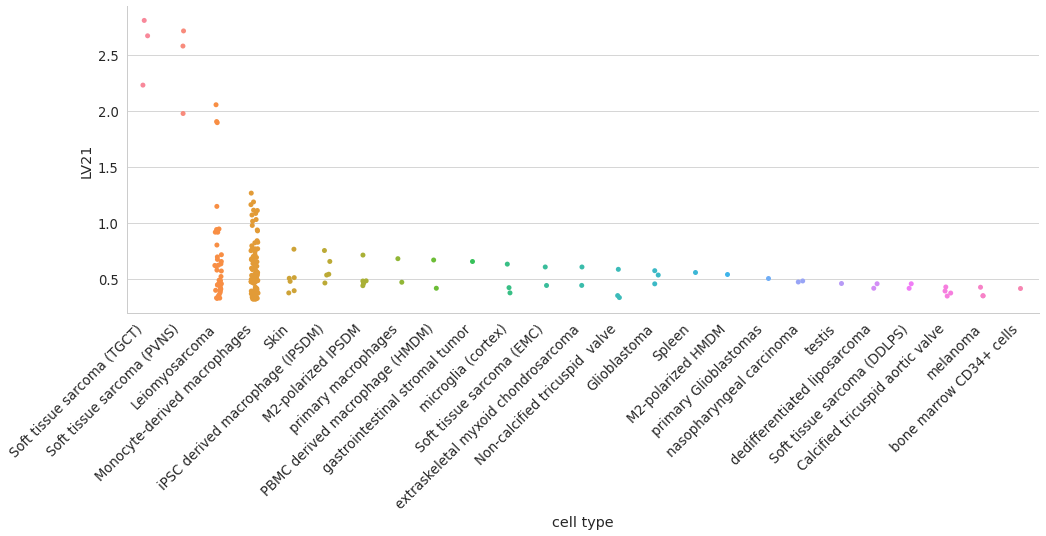

In [45]:
with sns.plotting_context("paper", font_scale=1.5), sns.axes_style("whitegrid"):
    sns.catplot(
        data=final_plot_data,
        y=LV_NAME,
        x=SELECTED_ATTRIBUTE,
        order=attr_order,
        kind="strip",
        height=5,
        aspect=3,
    )
    plt.xticks(rotation=45, horizontalalignment="right")

    plt.savefig(
        OUTPUT_CELL_TYPE_FILEPATH,
        bbox_inches="tight",
        facecolor="white",
    )

# Debug

In [46]:
# with pd.option_context(
#     "display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None
# ):
#     _tmp = final_plot_data[final_plot_data[SELECTED_ATTRIBUTE].str.contains("NOT CAT")]
#     display(_tmp.head(20))

In [47]:
# # what is there in these projects?
# lv_data.loc[["SRP036821"]].dropna(how="all", axis=1).sort_values(
#     LV_NAME, ascending=False
# ).head(60)